# Project: Mobile Manipulator Planning
**Course:** Roboterprogrammierung (Winter 25/26)  
**Institution:** Hochschule Karlsruhe - University of Applied Sciences (HKA)  

## 🎯 Objective
This notebook implements and evaluates a **Collision Checker** for a planar mobile robot consisting of a movable base and a 2-DOF rotatory arm. The goal is to benchmark path planning algorithms (LazyPRM, VisibilityPRM, etc.) in various environments while handling self-collisions and obstacle avoidance.

## ⚙️ Key Features
* **Mobile Base:** Free-form shape definition (2D).
* **Manipulator:** Configurable arm segments (Length, Thickness, Joint Limits).
* **Collision Detection:** Custom implementation handling Base-Obstacle, Arm-Obstacle, and Self-Collision (Arm-Base).

## Imports & Autoreload


In [1]:
# --- Auto-reload modules when source code changes ---
# This is crucial so you don't have to restart the kernel when editing src/ files
%load_ext autoreload
%autoreload 2

# --- Standard Imports ---
import copy

import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Needed for the custom legend
import matplotlib.ticker as ticker

import networkx as nx

import numpy as np

import os

import pandas as pd

import sys

from ipywidgets import interact, FloatSlider, Dropdown, Layout, Checkbox, Button, VBox, HBox, Output
from IPython.display import HTML, display, clear_output


# --- Add 'src' directory to path to import modules ---
# Assuming this notebook is in the 'notebooks/' folder and source is in 'src/'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
# IMPORTANT: To ensure that it finds its dependencies (IPTestSuite),
# we explicitly add the src folder to the path.
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)
# IMPORTANT: To ensure that IPLazyPRM finds its dependencies (IPPerfMonitor),
# we explicitly add the src/planners folder to the path.
planners_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'planners'))
if planners_path not in sys.path:
    sys.path.append(planners_path)

print(f"Project Root added to path: {project_root}")
print(f"Planner Root added to path: {planners_path}")

# --- Import Test Suite ---
from IPTestSuite import * #benchList, START, GOAL, LIMITS, ROBOT_BASE_SHAPE, ROBOT_ARM_CONFIG, ARM_OFFSET

# --- Import Animator ---
from IPAnimator import IPAnimator

# --- Import Performance Monitor ---
from IPPerfMonitor import IPPerfMonitor

# --- Import Result Collection ---
from IPResultCollection import ResultCollection

# --- Import Batch Evaluator
from IPBatchEvaluator import BatchEvaluator

# --- Import Planner Runner ---
from IPMultiGoalPlannerRunner import MultiGoalPlannerRunner

# --- Import Planners ---
# Visibility PRM
from IPVisibilityPRM import VisPRM as VisPRM
from IPVisibilityPRM_multiGoal import VisPRM as VisPRM_multiGoal
from IPVISVisibilityPRM import visibilityPRMVisualize
# Lazy PRM
from IPLazyPRM import LazyPRM as LazyPRM
from IPLazyPRM_multiGoal import LazyPRM as LazyPRM_multiGoal
from IPVISLazyPRM import lazyPRMVisualize


Project Root added to path: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator
Planner Root added to path: /Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners
TestSuite geladen. Benchmarks für Pick & Place konfiguriert.


## Creating Planner Factory

In [2]:
plannerFactory = dict()

visbilityConfig = dict()
visbilityConfig["ntry"] = 100
plannerFactory["visibilityPRM"] = [VisPRM, visbilityConfig, visibilityPRMVisualize]

lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 200
lazyConfig["updateRoadmapSize"]  = 50
lazyConfig["kNearest"] = 14
lazyConfig["maxIterations"] = 40
plannerFactory["lazyPRM"] = [LazyPRM, lazyConfig, lazyPRMVisualize]

print("Planner initialization successfull. Following Planners loaded:")
plannerNames = []
for planner in plannerFactory:
    plannerNames.append(planner)
    print(f"    {planner}")

print("Benchmarks initialization successfull. Following Benchmarks loaded:")
benchNames = []
for benchmark in benchList:
    benchNames.append(benchmark.name)
    print(f"    {benchmark.name}")

Planner initialization successfull. Following Planners loaded:
    visibilityPRM
    lazyPRM
Benchmarks initialization successfull. Following Benchmarks loaded:
    Empty World
    The Wall
    Narrow Passage
    Forest
    Shelf Reach


## Interactive Visualization

In [3]:
# --- Setup ---
# Namen für das Dropdown-Menü extrahieren
bench_names = [b.name for b in benchList]

def interact_bench_suite(bench_name, x, y, theta, q1, q2, attach_obj):
    """
    Interaktive Steuerung des Roboters in einer ausgewählten Benchmark-Umgebung.
    """
    plt.close('all')

    # 1. Den passenden Benchmark und CollisionChecker auswählen
    # Wir suchen das Benchmark-Objekt anhand des Namens
    current_bench = next(b for b in benchList if b.name == bench_name)
    cc = current_bench.collisionChecker

    # --- NEU: Objekt anhängen/abhängen basierend auf Checkbox ---
    # Wir greifen auf das globale PICK_OBJECT zu (oder current_bench.objectShape)
    if attach_obj:
        # Falls PICK_OBJECT nicht global verfügbar ist, nutze current_bench.objectShape
        obj_shape = cc.get_object_shape()
        cc.attach_object(obj_shape)
    else:
        cc.detach_object()
    # -----------------------------------------------------------

    # 3. Konfiguration erstellen (Numpy Array!)
    config = np.array([x, y, theta, q1, q2], dtype=float)

    # 4. Kollision prüfen
    try:
        if hasattr(cc, 'pointInCollision'):
            is_collision = cc.pointInCollision(config)
    except Exception as e:
        print(f"Fehler Collision Check: {e}")
        is_collision = True

    # 5. Zeichnen
    try:
        fig, ax = plt.subplots(figsize=(5, 5))
        
        # --- A. Hindernisse und aktueller Roboter ---
        cc.drawObstacles(ax)
        cc.drawRobot(config, ax, alpha=1)
        
        # --- B. Start und Ziel des Benchmarks einblenden (Hilfreich!) ---
        # Startkonfiguration (Grün gestrichelt)
        start_conf = np.array(current_bench.startList[0])
        # print(start_conf)
        # print(start_conf)
        geo_start = cc.get_robot_geometry(start_conf)
        ax.plot(*geo_start['base'].exterior.xy, color='green', linestyle='--', alpha=0.5, label='Start Base')
        
        # Zielkonfiguration (Rot gestrichelt)
        for goals in current_bench.goalList:
            # goalList Einträge können Tupel (Pos, Action) oder Listen (Pos) sein
            # Wir extrahieren sicherheitshalber nur die Koordinate
            goal_raw = goals[0] # if isinstance(goals, (tuple, list)) and len(goals) == 2 and isinstance(goals[1], str) else goals
            
            goal_conf = np.array(goal_raw)
            # print(goal_conf)
            
            # Farbe bestimmen (letztes Ziel rot, Zwischenziele lila)
            # Hinweis: Der Vergleich von Arrays benötigt .all()
            last_goal_raw = current_bench.goalList[-1]
            last_goal_coords = last_goal_raw[0] if isinstance(last_goal_raw, (tuple, list)) and len(last_goal_raw) == 2 and isinstance(last_goal_raw[1], str) else last_goal_raw
            
            if np.allclose(goal_conf, last_goal_coords):
                goal_color = 'red'
            else:
                goal_color = 'purple'
                
            geo_goal = cc.get_robot_geometry(goal_conf)
            ax.plot(*geo_goal['base'].exterior.xy, color=goal_color, linestyle='--', alpha=0.5, label='Goal Base')
        
        # Arme für Start/Ziel auch andeuten (optional, hier nur Basis der Übersicht halber)

        # --- C. Plot Settings ---
        ax.set_xlim(LIMITS) # Setzt min_x und max_x
        ax.set_ylim(LIMITS) # Setzt min_y und max_y
        ax.set_aspect('equal') # Verhindert Verzerrung (Kreise bleiben rund)

        ax.axis('on') 
        
        # Major Ticks auf 1.0
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
        
        # Minor Ticks auf 0.5
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        
        # Gitter zeichnen
        ax.grid(which='major', alpha=0.5, color='gray', linestyle='-')
        ax.grid(which='minor', alpha=0.2, color='gray', linestyle='--')
        
        # Labels anzeigen
        ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

        ax.legend(loc='upper left')

        # Titel & Status
        status_color = 'red' if is_collision else 'green'
        status_text = "COLLISION!" if is_collision else "FREE"
        attach_text = " [HOLDING OBJECT]" if attach_obj else ""
        
        ax.set_title(f"Scenario: {bench_name}{attach_text} \nStatus: {status_text} | Self check: {SELF_CHECK}", 
                     color=status_color, fontweight='bold', fontsize=14)
        
        plt.show()
        
    except Exception as e:
        print(f"Fehler beim Zeichnen: {e}")
        import traceback
        traceback.print_exc()
        

# --- Widgets erstellen ---
interact(interact_bench_suite, 
         bench_name=Dropdown(options=bench_names, description='Scenario:'),
         attach_obj=Checkbox(value=False, description='Attach Object'),
         x=FloatSlider(min=LIMITS[0], max=LIMITS[1], step=0.5, value=START[0][0]),
         y=FloatSlider(min=LIMITS[0], max=LIMITS[1], step=0.5, value=START[0][1]),
         theta=FloatSlider(min=-3.14, max=3.14, step=0.01, value=START[0][2], description='Base Theta'),
         # Die Limits für die Gelenke holen wir direkt aus der zentralen Config
         q1=FloatSlider(min=ROBOT_ARM_CONFIG[0][2][0], max=ROBOT_ARM_CONFIG[0][2][1], step=0.01, value=START[0][3], description='Joint 1'),
         q2=FloatSlider(min=ROBOT_ARM_CONFIG[1][2][0], max=ROBOT_ARM_CONFIG[1][2][1], step=0.01, value=START[0][4], description='Joint 2')
        );

interactive(children=(Dropdown(description='Scenario:', options=('Empty World', 'The Wall', 'Narrow Passage', …

## Planning

In [ ]:
resultList = list()
plotList = []

for key, producer in list(plannerFactory.items()):
    print("="*50)
    print(f"{key}:")
    for benchmark in benchList:
        print(f"    Running Benchmark {benchmark.name}")
        
        # Planner instanziieren
        planner = producer[0](benchmark.collisionChecker)
        config = producer[1]
        
        IPPerfMonitor.clearData()
        
        try:
            # --- Hier passiert jetzt die Magie in einer Zeile ---
            full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
            
            # Ergebnis speichern
            resultList.append(ResultCollection(
                plannerFactoryName=key,
                planner=planner, # Der Planner wurde in run_benchmark manipuliert (Graph, Edges)
                benchmark=benchmark,
                solution=full_path, 
                actions=action_events,
                perfDataFrame=IPPerfMonitor.dataFrame()
                )
            )
            plotList.append(1)
            
        except Exception as e:
            plotList.append(0)
            print("        PLANNING ERROR:", e)
            # Optional: Traceback für Details
            # import traceback
            # traceback.print_exc()
            pass

print("="*50)

visibilityPRM:
    Running Benchmark Empty World
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark The Wall
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        PLANNING ERROR:         [WARNING] No path found in segment 0
    Running Benchmark Narrow Passage
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 157, in run_benchmark
    raise Exception(f"        [WARNING] No path found in segment {i}")
Exception:         [WARNING] No path found in segment 0


        PLANNING ERROR:         [WARNING] No path found in segment 0
    Running Benchmark Forest
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 157, in run_benchmark
    raise Exception(f"        [WARNING] No path found in segment {i}")
Exception:         [WARNING] No path found in segment 0


        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark Shelf Reach
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        PLANNING ERROR:         [WARNING] No path found in segment 0
lazyPRM:
    Running Benchmark Empty World
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 157, in run_benchmark
    raise Exception(f"        [WARNING] No path found in segment {i}")
Exception:         [WARNING] No path found in segment 0


        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark The Wall
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        PLANNING ERROR:         [WARNING] No path found in segment 0
    Running Benchmark Narrow Passage
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 157, in run_benchmark
    raise Exception(f"        [WARNING] No path found in segment {i}")
Exception:         [WARNING] No path found in segment 0


        PLANNING ERROR:         [WARNING] No path found in segment 0
    Running Benchmark Forest
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 157, in run_benchmark
    raise Exception(f"        [WARNING] No path found in segment {i}")
Exception:         [WARNING] No path found in segment 0


        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
    Running Benchmark Shelf Reach
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        PLANNING ERROR: No valid start


Traceback (most recent call last):
  File "/var/folders/2s/hdwnmw897sz7w6sdh3ywjg3m0000gn/T/ipykernel_93961/181520108.py", line 18, in <module>
    full_path, action_events = MultiGoalPlannerRunner.run_benchmark(planner, benchmark, config)
                               ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPMultiGoalPlannerRunner.py", line 154, in run_benchmark
    segment = planner.planPath(current_start, current_goal_list_for_planner, config)
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPPerfMonitor.py", line 29, in __call__
    ret = self.__f(*args, **kwargs)
  File "/Users/glaserpaul/Documents/010_HKA_RKIM/Mobiler_Manipulator/src/planners/IPLazyPRM.py", line 104, in planPath
    checkedStartList, checkedGoalList = self._checkStartGoal(startList,goalList)
                                        ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^
 

## Visualization

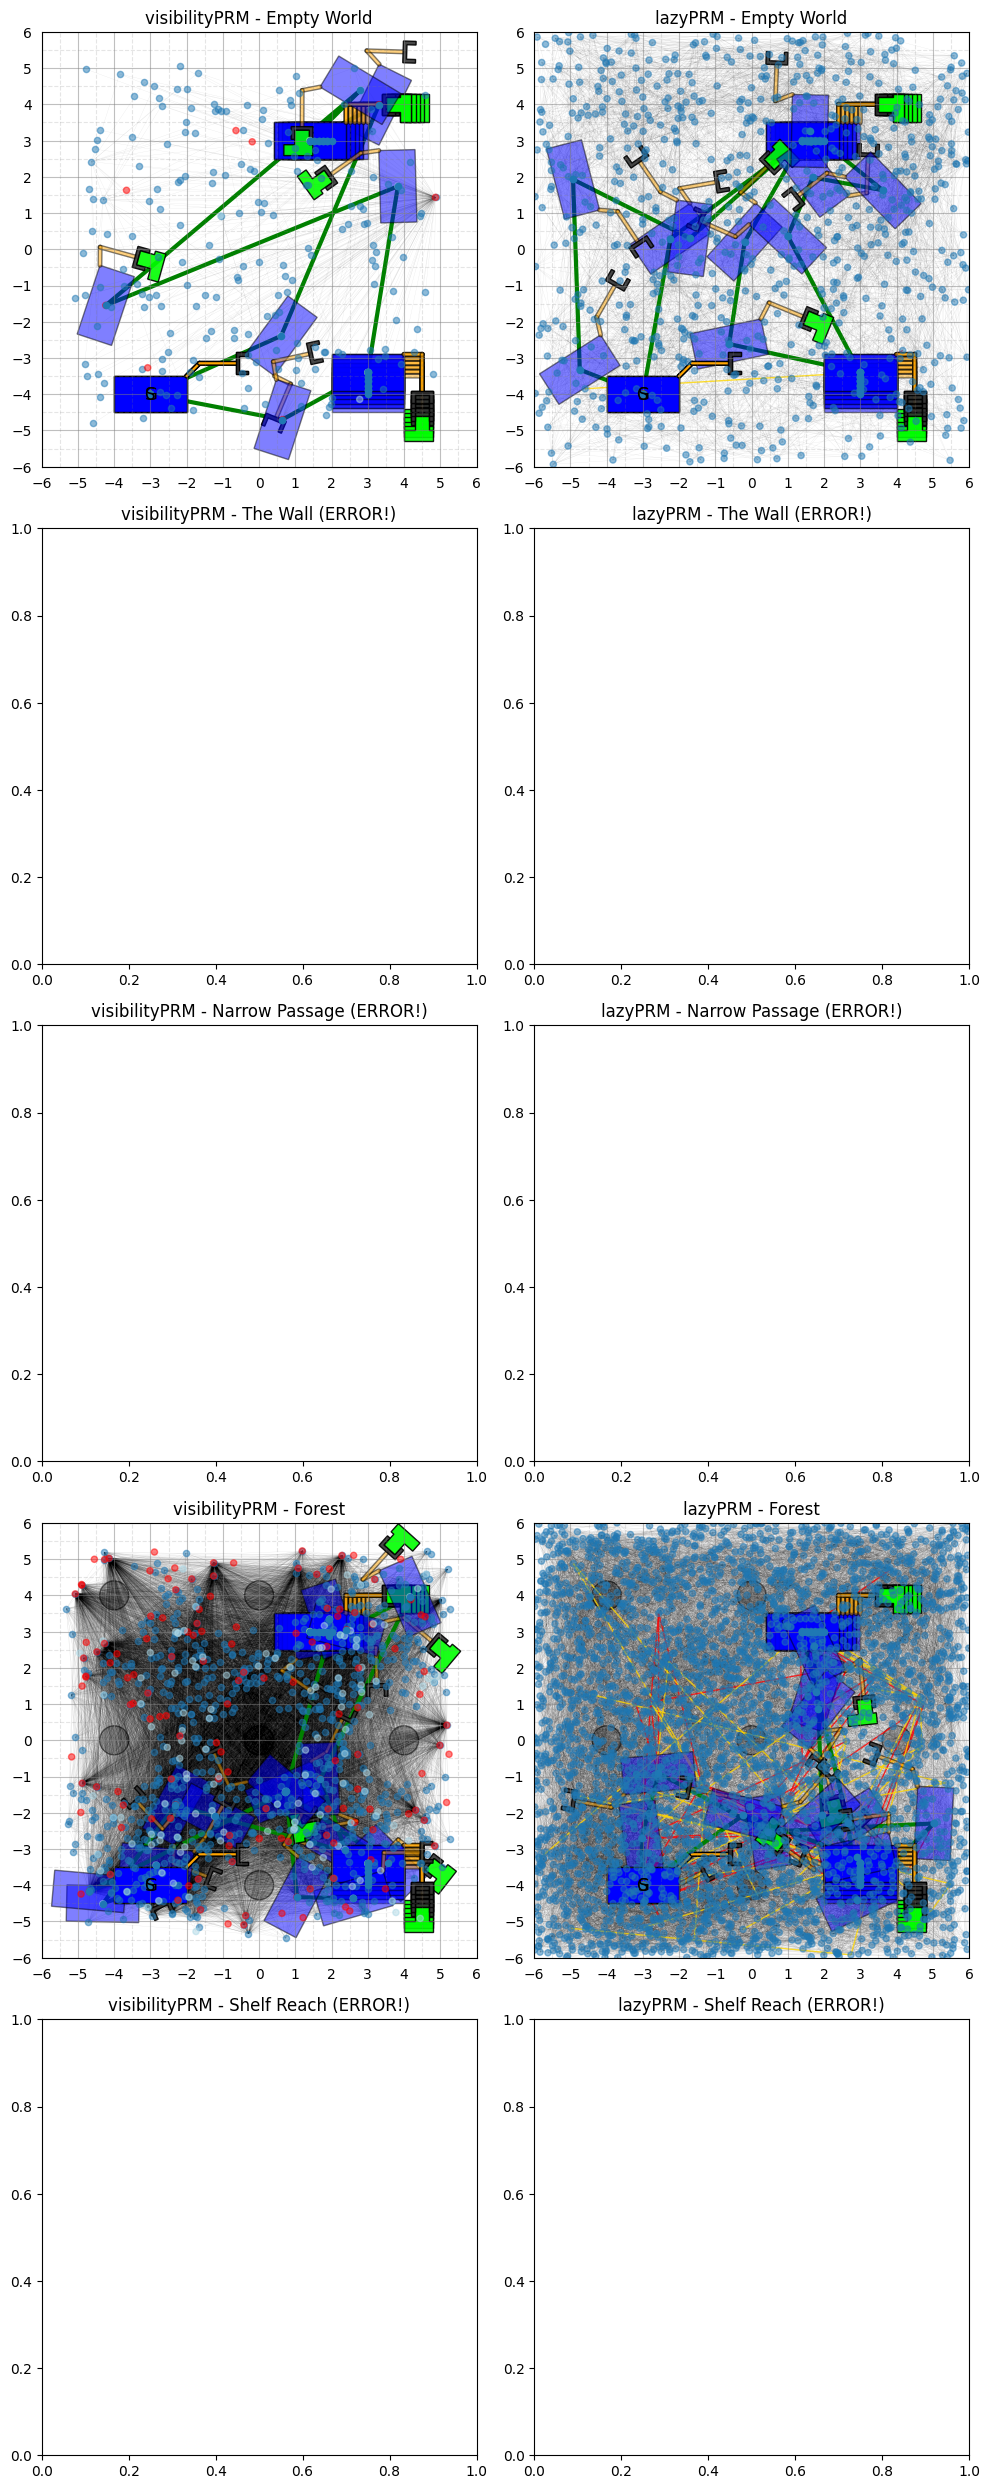

In [5]:
fig, axes = plt.subplots(len(benchList), len(plannerFactory), figsize=(len(plannerFactory)*5, len(benchList)*5), squeeze=False)
resultList_iter = iter(resultList)

do_prints = False

for i, _ in enumerate(plotList):
    row_idx = i % len(benchList)
    col_idx = i // len(benchList)

    ax = axes[row_idx, col_idx]

    title = plannerNames[col_idx] + " - " + benchNames[row_idx]
    if do_prints:
        print("="*50)
        print(f"{title} | {row_idx}, {col_idx}")

    if plotList[i]==0:
        if do_prints:
            print("    ERROR --> next one")
        title += " (ERROR!)"
        ax.set_title(title)
        continue
    else:
        if do_prints:
            print("    PLANNED --> plotting")

    result = next(resultList_iter)

    if result.solution == []:
        title += " (No path found!)"
    ax.set_title(title)

    try:
        # 1. Plotten
        plannerFactory[result.plannerFactoryName][2](result.planner, result.solution, result.actions, ax=ax, nodeSize=20, plot_only_solution=False)
        
        # --- NEU: Limits und Seitenverhältnis setzen ---
        # Wir holen uns die Grenzen aus dem Collision Checker des Benchmarks
        # Rückgabeformat ist meist: [[min_x, max_x], [min_y, max_y]]
        limits = result.benchmark.collisionChecker.getEnvironmentLimits()
        
        ax.set_xlim(limits[0]) # Setzt min_x und max_x
        ax.set_ylim(limits[1]) # Setzt min_y und max_y
        ax.set_aspect('equal') # Verhindert Verzerrung (Kreise bleiben rund)

        # --- Grid und Achsen Formatierung ---
        ax.axis('on') 
        
        # Major Ticks auf 1.0
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
        
        # Minor Ticks auf 0.5
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
        
        # Gitter zeichnen
        ax.grid(which='major', alpha=0.5, color='gray', linestyle='-')
        ax.grid(which='minor', alpha=0.2, color='gray', linestyle='--')
        
        # Labels anzeigen
        ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)

    except Exception as e:
        print ("Error", e)
        # import traceback
        # traceback.print_exc()
        pass

plt.tight_layout()
if do_prints:
    print("="*50)

## Visualization with Animation

In [ ]:
# Setup Limits (falls nicht global vorhanden)
try:
    anim_limits = LIMITS
except NameError:
    anim_limits = (-10, 25)

# UI erstellen und anzeigen
ui = IPAnimator.create_interactive_viewer(plannerFactory, resultList, limits=anim_limits)
display(ui)

## Benchmark

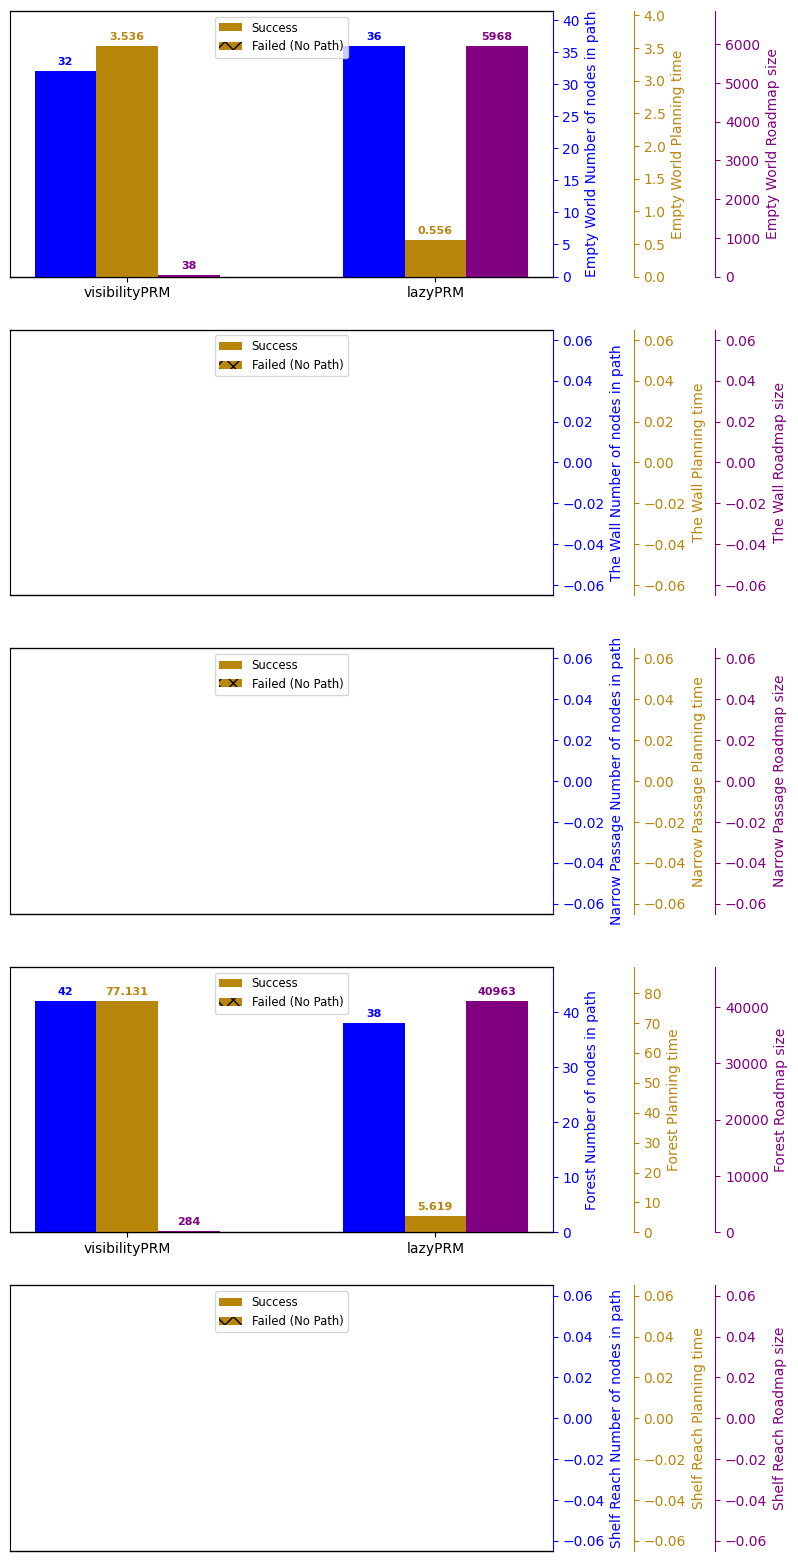

In [7]:
# --- Helper Function for Value Labels ---
def add_labels(ax, rects, color, fmt='{:.0f}', offset=3):
    """
    Attaches a text label above each bar in *rects*, displaying its height.
    
    Args:
        ax: The axis to draw on.
        rects: The bar container (returned by ax.bar).
        color: Text color.
        fmt: Format string (e.g., '{:.0f}' for int, '{:.3f}' for float).
        offset: Vertical offset in points.
    """
    for rect in rects:
        height = rect.get_height()
        # Optional: Skip 0 values to keep chart clean, or keep them if significant
        if height == 0: 
            continue 
            
        ax.annotate(fmt.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),  # Offset points vertically
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color=color, fontsize=8, fontweight='bold')

# --- Setup the Figure ---
# squeeze=False ensures 'axes' is always a 2D array, even if there is only one plot.
# We increase the figure height dynamically based on the number of planners.
fig, axes = plt.subplots(len(benchList), 1, figsize=(7, len(plannerFactory)*10), squeeze=False)

# --- CRITICAL LAYOUT ADJUSTMENT ---
# We reserve space on the right side (0.75 means the plot ends at 75% of the width).
# This empty space is needed to place the multiple y-axes (darkgoldenrod and Purple) 
# without them getting cut off or overlapping.
# plt.subplots_adjust(right=0.75) 

for i, bench in enumerate(benchList):
    title = bench.name
    
    # Dictionaries to store metrics
    pathLength = dict()
    planningTime = dict()
    roadmapSize  = dict()
    
    try:
        # --- 1. Data Collection ---
        # Iterate through results to gather metrics for the current benchmark
        for result in resultList:
            if result.benchmark.name == bench.name:
                # Metric: Length of the found path (number of nodes)
                pathLength[result.plannerFactoryName] = len(result.solution)
                
                # Metric: Total planning time
                # Using numeric_only=True to avoid pandas errors with non-numeric data
                planningTime[result.plannerFactoryName] = result.perfDataFrame.groupby(["name"]).sum(numeric_only=True)["time"]["planPath"]
                
                # Metric: Size of the generated roadmap (graph size)
                roadmapSize[result.plannerFactoryName] = result.planner.graph.size()

        # --- 2. Axis Setup (The "Ghost Axis" Strategy) ---
        # We use the main axis 'ax' ONLY as a container for the left border and the x-axis.
        # We do NOT plot data on 'ax' directly to avoid the left-side dominance issue of twinx().
        ax = axes[i, 0]
        width = 0.2
        
        # Configure X-Axis (Shared by all bars)
        ax.set_xticks(np.arange(len(pathLength.keys())) + width)
        ax.set_xticklabels(pathLength.keys())
        
        # Configure Left Y-Axis (The Ghost Axis)
        # We remove the ticks/numbers but keep the spine (line) to create a clean left border.
        ax.set_yticks([])                    # Remove numbers
        ax.spines['left'].set_visible(True)  # Show left line
        ax.spines['left'].set_color("black") # Color it black
        ax.spines['right'].set_visible(False)# Hide right spine (handled by other axes)
        ax.spines['top'].set_visible(False)  # Hide top spine

        # --- 3. BLUE AXIS: Path Length (First Twin) ---
        # twinx() creates a new axis overlaid on 'ax'. By default, twinx axes are on the RIGHT.
        ax_blue = ax.twinx() 
        
        # Plot Blue Bars
        blue_bars = ax_blue.bar(np.arange(len(pathLength.keys())), pathLength.values(), width, color="blue")
        ax_blue.set_ylabel(title + " Number of nodes in path", color="blue")
        
        # Style the Blue Axis (Inner Right)
        ax_blue.spines['right'].set_color("blue")     # Color the line blue
        ax_blue.tick_params(axis='y', colors='blue')  # Color the numbers blue
        ax_blue.spines['left'].set_visible(False)     # Ensure left side is empty

        # Make space for bar labeling
        ax_blue.margins(y=0.15)

        # Add Labels (Integer)
        add_labels(ax_blue, blue_bars, "blue", fmt='{:.0f}')

        # --- 4. DARKGOLDENROD AXIS: Planning Time (Second Twin) ---
        ax_darkgoldenrod = ax.twinx()
        
        # Logic for coloring: 
        # If pathLength is 0 (failure), use DARKGOLDENROD color and 'x' hatch pattern.
        # Otherwise (success), use darkgoldenrod color.
        hatches = ['xx' if length==0 else '' for length in pathLength.values()]
        bar_colors = ['darkgoldenrod' if length==0 else 'darkgoldenrod' for length in pathLength.values()]
        
        # Plot Bars (initially red, but we update facecolor individually below)
        darkgoldenrod_bars = ax_darkgoldenrod.bar(np.arange(len(pathLength.keys()))+width, planningTime.values(), width, color="red")
        
        # Apply custom colors and hatches to each bar
        for j, thisbar in enumerate(darkgoldenrod_bars.patches):
            thisbar.set_facecolor(bar_colors[j])
            thisbar.set_hatch(hatches[j])
            
        ax_darkgoldenrod.set_ylabel(title + " Planning time", color="darkgoldenrod") 
        
        # Move this axis to the right (Offset: 1.15)
        ax_darkgoldenrod.spines['right'].set_position(('axes', 1.15)) # 15% further out
        ax_darkgoldenrod.spines['right'].set_visible(True)
        ax_darkgoldenrod.spines['right'].set_color("darkgoldenrod")
        ax_darkgoldenrod.tick_params(axis='y', colors='darkgoldenrod')
        ax_darkgoldenrod.spines['left'].set_visible(False)

        # Make space for bar labeling
        ax_darkgoldenrod.margins(y=0.15)

        # Add Labels (Float with 3 decimals for time)
        add_labels(ax_darkgoldenrod, darkgoldenrod_bars, "darkgoldenrod", fmt='{:.3f}')

        # --- 5. PURPLE AXIS: Roadmap Size (Third Twin) ---
        ax_purple = ax.twinx()
        purple_bars = ax_purple.bar(np.arange(len(pathLength.keys()))+2*width, roadmapSize.values(), width, color="purple")
        ax_purple.set_ylabel(title + " Roadmap size", color="purple")
        
        # Move this axis further to the right (Offset: 1.30)
        ax_purple.spines['right'].set_position(('axes', 1.30)) # 30% further out
        ax_purple.spines['right'].set_visible(True)
        ax_purple.spines['right'].set_color("purple")
        ax_purple.tick_params(axis='y', colors='purple')
        ax_purple.spines['left'].set_visible(False)

        # Make space for bar labeling
        ax_purple.margins(y=0.15)

        # Add Labels (Integer)
        add_labels(ax_purple, purple_bars, "purple", fmt='{:.0f}')

        # --- 6. LEGEND: Explaining Red vs. Darkgoldenrod ---
        # Since we set colors manually per bar, standard legend() call won't work automatically.
        # We create "Proxy Artists" (custom patches) to define the legend entries.
        legend_handles = [
            mpatches.Patch(facecolor='darkgoldenrod', label='Success'),
            mpatches.Patch(facecolor='darkgoldenrod', hatch='xx', label='Failed (No Path)')
        ]
        # Place legend in the upper left corner of the plot
        ax_purple.legend(handles=legend_handles, loc='upper center', fontsize='small', framealpha=0.8)

    except Exception as e:
        print("Error processing benchmark:", bench.name)
        print(e)
        import traceback
        traceback.print_exc()
        pass

# Show final plot
plt.show()

## Batch Evaluator

In [10]:
# --- KONFIGURATION ---
NUMBER_OF_RUNS = 10  # Wie oft soll jeder Test wiederholt werden?

print(f"Starting Evaluation with {NUMBER_OF_RUNS} runs per scenario...")

# Batch starten
df_results = BatchEvaluator.run_experiment(plannerFactory, benchList, num_runs=NUMBER_OF_RUNS)

print("Evaluation finished.")
# Kurzer Blick auf die Daten (erste 5 Zeilen)
display(df_results.head())

# Optional: Speichern als CSV, damit die Daten nicht verloren gehen
# df_results.to_csv(f"benchmark_results_{NUMBER_OF_RUNS}runs.csv", index=False)

Starting Evaluation with 10 runs per scenario...


Running Batch Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment 0: PICK with offset [0.6, 0.0]. Planning to Standoff.
        [Action] PICK: Removed static object.
        [Action] PICK: Grasping.
        [Runner] Segment 1: PLACE with offset [0.0, -0.6]. Planning to Standoff.
        [Action] PLACE: Releasing.
        [Action] PLACE: Object becomes obstacle.
        [Runner] Segment 2: MOVE. Planning directly to target.
        [Setup] Initial object placed at Pick-Location as obstacle.
        [Runner] Segment

,Planner,Benchmark,RunID,Success,Time,PathLength,GraphNodes,Error
0,visibilityPRM,Empty World,0,True,3.446775,32.0,43,
1,visibilityPRM,Empty World,1,True,5.349210,34.0,49,
2,visibilityPRM,Empty World,2,True,5.003792,33.0,47,
3,visibilityPRM,Empty World,3,True,4.181033,29.0,45,
4,visibilityPRM,Empty World,4,True,4.199786,34.0,47,


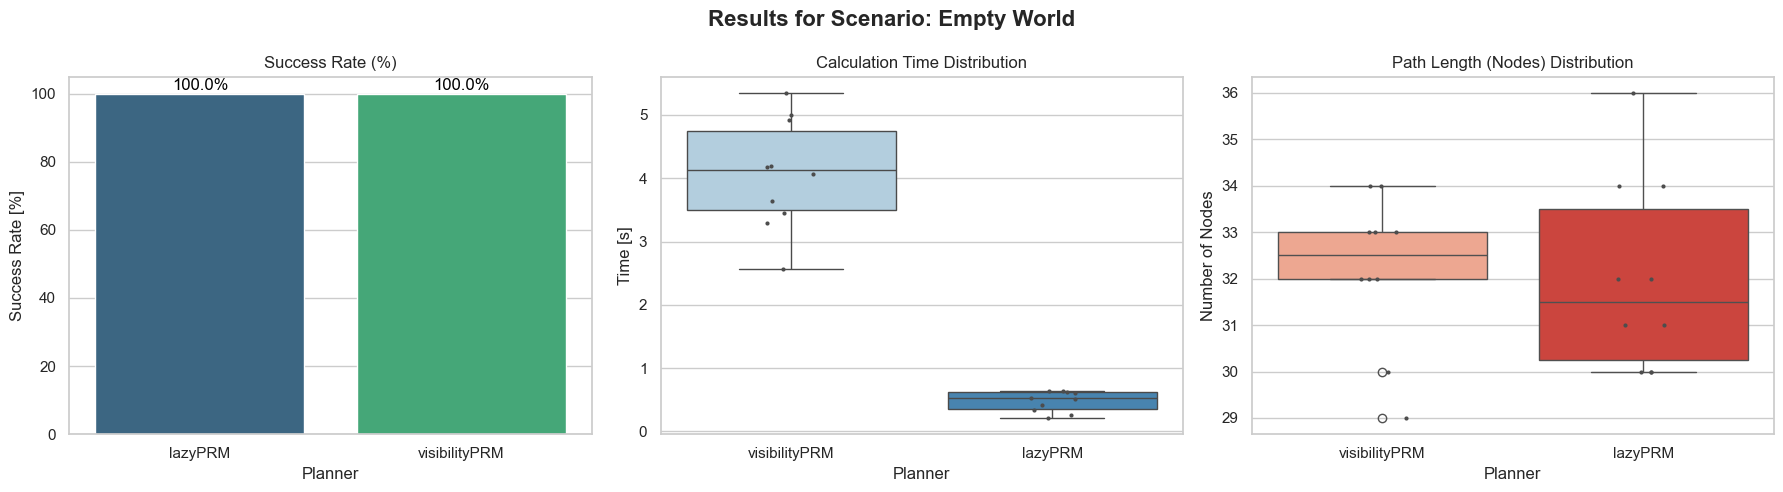

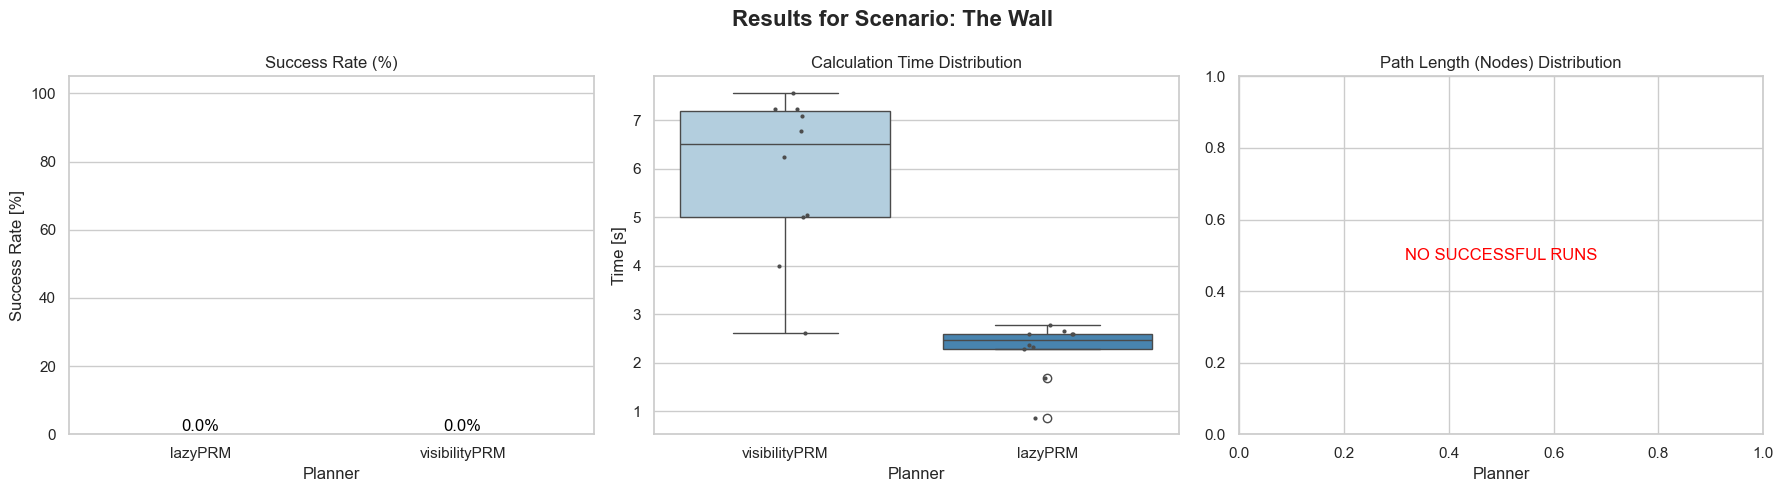

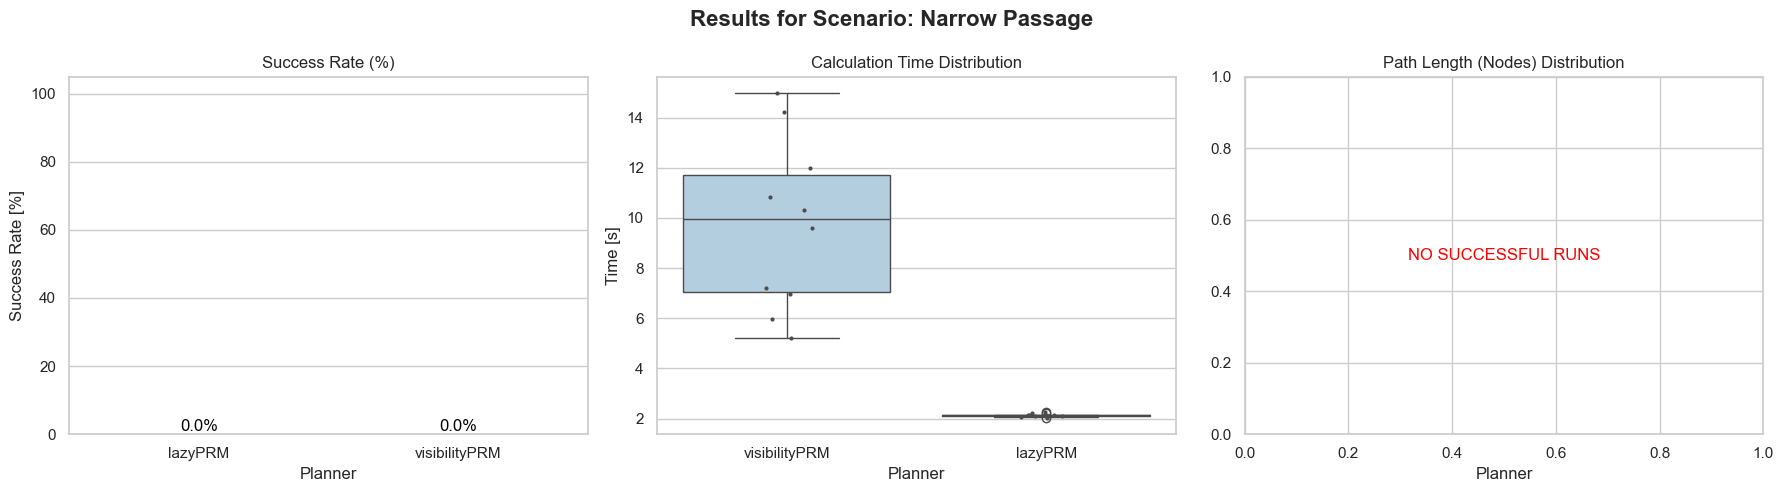

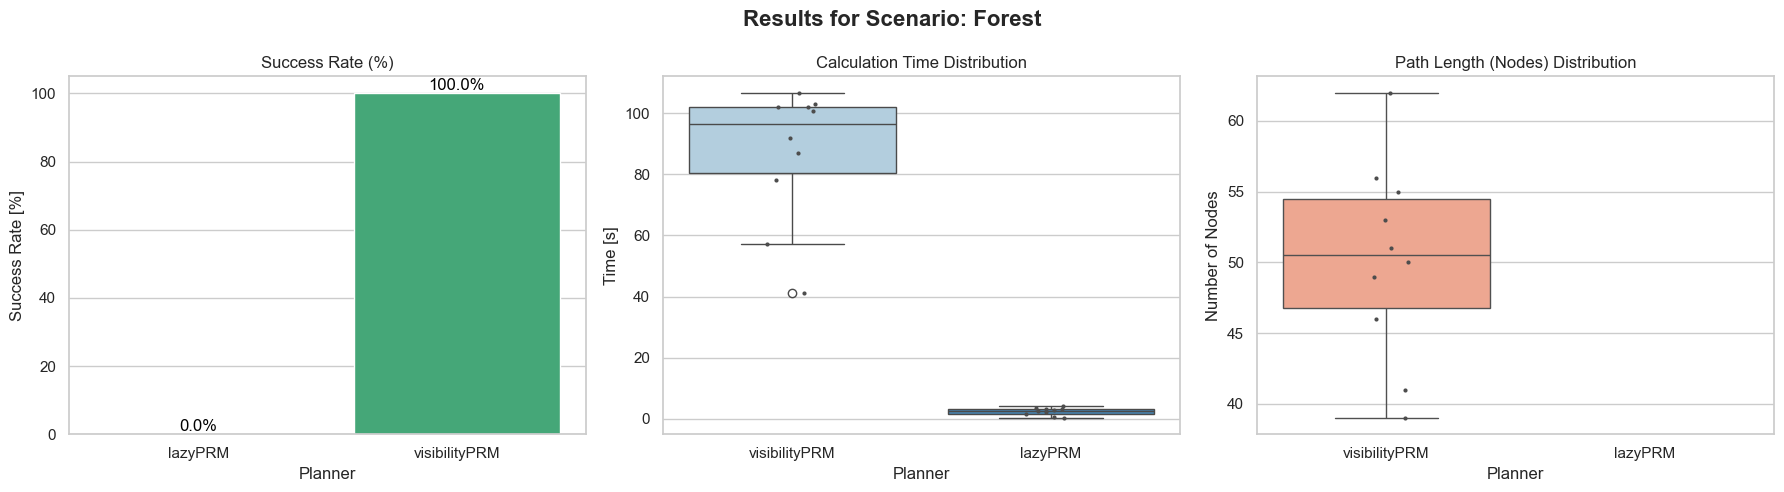

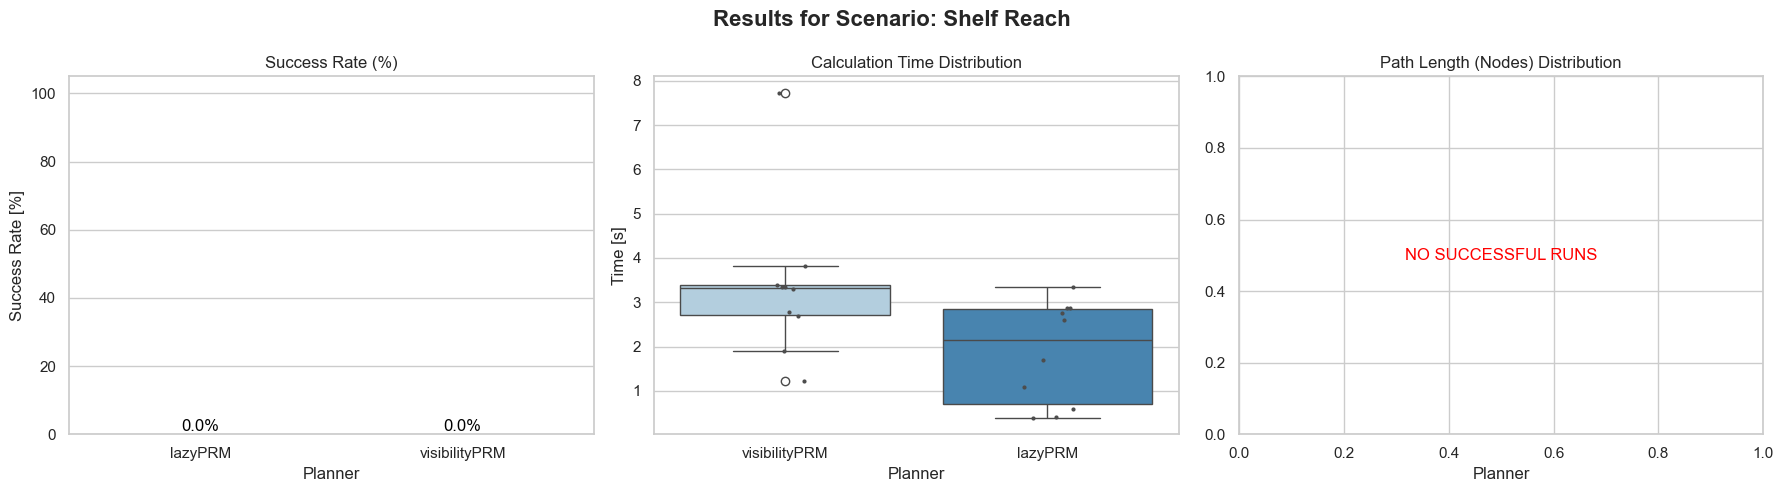

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Styling
sns.set_theme(style="whitegrid")

unique_benchmarks = df_results["Benchmark"].unique()

for bench_name in unique_benchmarks:
    # Daten filtern
    df_bench = df_results[df_results["Benchmark"] == bench_name]
    
    # Prüfen, ob überhaupt erfolgreiche Runs existieren (für PathLength relevant)
    has_successes = df_bench["Success"].any()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Results for Scenario: {bench_name}", fontsize=16, fontweight='bold')
    
    # --- PLOT 1: SUCCESS RATE ---
    success_rates = df_bench.groupby("Planner")["Success"].mean().reset_index()
    success_rates["Success"] *= 100 
    
    # FIX: hue="Planner" und legend=False gegen die Warnung
    sns.barplot(data=success_rates, x="Planner", y="Success", ax=axes[0], hue="Planner", palette="viridis", legend=False)
    axes[0].set_title("Success Rate (%)")
    axes[0].set_ylim(0, 105)
    axes[0].set_ylabel("Success Rate [%]")
    
    for index, row in success_rates.iterrows():
        axes[0].text(index, row.Success + 1, f"{row.Success:.1f}%", color='black', ha="center")

    # --- PLOT 2: PLANNING TIME ---
    # Zeit haben wir immer (auch bei Fail), daher unkritisch, aber hue hinzufügen
    sns.boxplot(data=df_bench, x="Planner", y="Time", ax=axes[1], hue="Planner", palette="Blues", legend=False)
    sns.stripplot(data=df_bench, x="Planner", y="Time", color=".3", size=3, ax=axes[1])
    axes[1].set_title("Calculation Time Distribution")
    axes[1].set_ylabel("Time [s]")

    # --- PLOT 3: PATH LENGTH ---
    # FIX: Nur plotten, wenn wir Daten haben (sonst Crash)
    if has_successes:
        # Wir filtern NaNs heraus, nur um sicherzugehen, aber Seaborn sollte NaNs ignorieren, 
        # solange WENIGSTENS EIN Wert da ist.
        sns.boxplot(data=df_bench, x="Planner", y="PathLength", ax=axes[2], hue="Planner", palette="Reds", legend=False)
        sns.stripplot(data=df_bench, x="Planner", y="PathLength", color=".3", size=3, ax=axes[2])
        axes[2].set_title("Path Length (Nodes) Distribution")
        axes[2].set_ylabel("Number of Nodes")
    else:
        # Fallback: Leerer Plot mit Text
        axes[2].text(0.5, 0.5, "NO SUCCESSFUL RUNS", ha='center', va='center', fontsize=12, color='red')
        axes[2].set_title("Path Length (Nodes) Distribution")
        axes[2].set_xlabel("Planner")

    plt.tight_layout()
    plt.show()